In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import joblib
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('exoplanet_habitability.csv')
df = pd.DataFrame(data)
df.head()

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,sy_snum,sy_pnum,...,sy_kepmagerr2,sy_kepmag_reflink,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec,habitability
0,1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,2,1,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,2,1,2,0,0,0,0,0.0
1,2,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,1,1,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,1,0,0,0,0,0.0
2,3,14 And b,14 And,b,HD 221345,HIP 116076,TIC 333225860,Gaia DR2 1920113512486282240,1,1,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,1,0,0,0,0,0.0
3,4,14 Her b,14 Her,b,HD 145675,HIP 79248,TIC 219483057,Gaia DR2 1385293808145621504,1,2,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,4,1,0,0,0,0.0
4,5,16 Cyg B b,16 Cyg B,b,HD 186427,HIP 96901,TIC 27533327,Gaia DR2 2135550755683407232,3,1,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,5,1,4,3,0,0,0,0.0


In [ ]:
data = pd.read_csv('modified_exoplanet_habitability.csv')
df = pd.DataFrame(data)
df.head()

,rowid,pl_name,hostname,sy_snum,sy_pnum,sy_mnum,cb_flag,rv_flag,pul_flag,ptv_flag,...,sy_kepmagerr2,sy_kepmag_reflink,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec,habitability
0,1,11 Com b,11 Com,2,1,0,0,1,0,0,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,2,1,2,0,0,0,0,0.0
1,2,11 UMi b,11 UMi,1,1,0,0,1,0,0,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,1,0,0,0,0,0.0
2,3,14 And b,14 And,1,1,0,0,1,0,0,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,1,0,0,0,0,0.0
3,4,14 Her b,14 Her,1,2,0,0,1,0,0,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,4,1,0,0,0,0.0
4,5,16 Cyg B b,16 Cyg B,3,1,0,0,1,0,0,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,5,1,4,3,0,0,0,0.0


In [ ]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
class MixedDensityNetwork(nn.Module):

    def __init__(self, input_dim, hidden_dims=[256, 128, 64], n_components=3, dropout=0.3, n_classes=3):
        super(MixedDensityNetwork, self).__init__()

        self.input_dim = input_dim
        self.n_components = n_components
        self.n_classes = n_classes

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim

        self.shared_layers = nn.Sequential(*layers)

        self.mixture_weights = nn.Linear(prev_dim, n_components)
        self.mixture_means = nn.Linear(prev_dim, n_components)
        self.mixture_stds = nn.Linear(prev_dim, n_components)

        self.classifier = nn.Linear(prev_dim, n_classes)

        self.ordinal_regression = nn.Linear(prev_dim, 1)

    def forward(self, x):
        shared_out = self.shared_layers(x)

        weights = F.softmax(self.mixture_weights(shared_out), dim=1)
        means = torch.sigmoid(self.mixture_means(shared_out))
        stds = F.softplus(self.mixture_stds(shared_out)) + 1e-6

        class_logits = self.classifier(shared_out)
        class_probs = F.softmax(class_logits, dim=1)

        ordinal_output = torch.sigmoid(self.ordinal_regression(shared_out))

        return weights, means, stds, class_probs, ordinal_output

    def sample(self, weights, means, stds, n_samples=1000):
        batch_size = weights.shape[0]
        samples = []

        for i in range(batch_size):
            component_choices = torch.multinomial(weights[i], n_samples, replacement=True)

            batch_samples = torch.zeros(n_samples)
            for j in range(self.n_components):
                mask = component_choices == j
                n_comp_samples = mask.sum().item()
                if n_comp_samples > 0:
                    batch_samples[mask] = torch.normal(
                        means[i, j].repeat(n_comp_samples),
                        stds[i, j].repeat(n_comp_samples)
                    )

            samples.append(batch_samples)

        return torch.stack(samples)

In [ ]:
def create_target_mapping():
    value_to_class = {0.0: 0, 0.6: 1, 0.9: 2}
    class_to_value = {0: 0.0, 1: 0.6, 2: 0.9}
    continuous_values = [0.0, 0.6, 0.9]

    return value_to_class, class_to_value, continuous_values

In [ ]:
def mdn_loss_discrete(weights, means, stds, class_probs, ordinal_output, y_discrete, alpha=0.3, beta=0.3):

    value_to_class, class_to_value, continuous_values = create_target_mapping()

    y_continuous = torch.tensor([continuous_values[int(val * 10 / 6)] if val in [0.0, 0.6, 0.9]
                                else val for val in y_discrete.cpu().numpy()]).float().to(device)

    y_class_indices = torch.tensor([value_to_class.get(float(val), 0)
                                   for val in y_discrete.cpu().numpy()]).long().to(device)

    y_expanded = y_continuous.unsqueeze(1).expand_as(means)
    normal_dist = torch.distributions.Normal(means, stds)
    component_probs = normal_dist.log_prob(y_expanded).exp()
    mixture_prob = torch.sum(weights * component_probs, dim=1)
    mdn_loss_val = -torch.log(mixture_prob + 1e-8).mean()

    classification_loss = F.cross_entropy(class_probs, y_class_indices)

    ordinal_loss = F.mse_loss(ordinal_output.squeeze(), y_continuous)

    total_loss = alpha * mdn_loss_val + beta * classification_loss + (1 - alpha - beta) * ordinal_loss

    return total_loss, mdn_loss_val, classification_loss, ordinal_loss

In [ ]:
def select_relevant_columns(df):

    core_features = [
        'pl_name', 'pl_rade', 'pl_bmasse', 'pl_dens', 'pl_eqt',
        'pl_orbper', 'pl_orbsmax', 'pl_orbeccen', 'pl_insol', 'pl_orbincl'
    ]

    stellar_features = [
        'st_teff', 'st_rad', 'st_mass', 'st_lum', 'st_age', 'st_met', 'st_spectype'
    ]

    system_features = [
        'sy_snum', 'sy_pnum', 'sy_dist'
    ]

    detection_flags = ['tran_flag', 'rv_flag', 'ima_flag']

    target_columns = ['habitability']

    potential_columns = core_features + stellar_features + system_features + detection_flags + target_columns

    existing_columns = [col for col in potential_columns if col in df.columns]

    print(f"Available columns in dataset: {len(df.columns)}")
    print(f"Selected {len(existing_columns)} existing columns from {len(potential_columns)} potential columns")
    print(f"Missing columns: {set(potential_columns) - set(existing_columns)}")

    return df[existing_columns].copy()

In [ ]:
def validate_habitability_values(df):

    if 'habitability' not in df.columns:
        raise ValueError("'habitability' column not found in dataset")

    print("\nHabitability value distribution:")
    print(df['habitability'].value_counts().sort_index())

    expected_values = [0.0, 0.6, 0.9]
    unique_values = df['habitability'].dropna().unique()
    print(f"\nUnique habitability values found: {sorted(unique_values)}")

    def round_to_nearest_expected(val):
        if pd.isna(val):
            return val
        distances = [abs(val - exp_val) for exp_val in expected_values]
        return expected_values[np.argmin(distances)]

    df_clean = df.copy()
    df_clean['habitability_original'] = df_clean['habitability'].copy()
    df_clean['habitability'] = df_clean['habitability'].apply(round_to_nearest_expected)

    print(f"\nAfter cleaning:")
    print(df_clean['habitability'].value_counts().sort_index())

    return df_clean

In [ ]:
def preprocess_exoplanet_data_discrete(df):

    df_processed = df.copy()

    categorical_cols = ['st_spectype']

    for col in categorical_cols:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna('Unknown')
            top_categories = df_processed[col].value_counts().head(10).index.tolist()
            df_processed[col] = df_processed[col].apply(
                lambda x: x if x in top_categories else 'Other'
            )

    detection_flags = ['tran_flag', 'rv_flag', 'ima_flag']
    for flag in detection_flags:
        if flag in df_processed.columns:
            df_processed[flag] = df_processed[flag].fillna(0).astype(int)

    if 'pl_rade' in df_processed.columns and 'st_rad' in df_processed.columns:
        df_processed['planet_star_radius_ratio'] = df_processed['pl_rade'] / (df_processed['st_rad'] * 109.2)

    if 'pl_orbsmax' in df_processed.columns and 'st_lum' in df_processed.columns:
        st_lum_linear = 10 ** df_processed['st_lum'].fillna(0)
        hz_inner = np.sqrt(st_lum_linear * 0.95)
        hz_outer = np.sqrt(st_lum_linear * 1.67)

        df_processed['in_habitable_zone'] = (
            (df_processed['pl_orbsmax'] >= hz_inner) &
            (df_processed['pl_orbsmax'] <= hz_outer)
        ).astype(int)

        df_processed['hz_distance_ratio'] = df_processed['pl_orbsmax'] / np.sqrt(st_lum_linear)

    if 'pl_dens' in df_processed.columns:
        df_processed['is_rocky'] = ((df_processed['pl_dens'] >= 3) &
                                   (df_processed['pl_dens'] <= 8)).fillna(False).astype(int)

    if 'pl_bmasse' in df_processed.columns:
        df_processed['is_super_earth'] = ((df_processed['pl_bmasse'] >= 1) &
                                         (df_processed['pl_bmasse'] <= 10)).fillna(False).astype(int)
        df_processed['is_earth_size'] = ((df_processed['pl_bmasse'] >= 0.5) &
                                        (df_processed['pl_bmasse'] <= 2)).fillna(False).astype(int)

    if 'st_age' in df_processed.columns:
        df_processed['is_mature_star'] = ((df_processed['st_age'] >= 1) &
                                         (df_processed['st_age'] <= 10)).fillna(False).astype(int)

    if 'sy_pnum' in df_processed.columns:
        df_processed['is_multi_planet'] = (df_processed['sy_pnum'] > 1).fillna(False).astype(int)

    if 'sy_snum' in df_processed.columns:
        df_processed['is_multi_star'] = (df_processed['sy_snum'] > 1).fillna(False).astype(int)

    potential_log_cols = ['pl_orbper', 'pl_bmasse', 'sy_dist', 'pl_insol', 'st_age']
    log_cols = [col for col in potential_log_cols if col in df_processed.columns]

    for col in log_cols:
        mask = (df_processed[col] > 0) & df_processed[col].notna()
        if mask.sum() > 0:
            df_processed.loc[mask, f'log_{col}'] = np.log10(df_processed.loc[mask, col])

    if 'pl_orbper' in df_processed.columns and 'pl_orbsmax' in df_processed.columns:
        mask = (df_processed['pl_orbper'].notna()) & (df_processed['pl_orbsmax'].notna()) & \
               (df_processed['pl_orbper'] > 0) & (df_processed['pl_orbsmax'] > 0)
        if mask.sum() > 0:
            df_processed.loc[mask, 'orbital_velocity'] = (
                2 * np.pi * df_processed.loc[mask, 'pl_orbsmax'] /
                (df_processed.loc[mask, 'pl_orbper'] / 365.25)
            )

    if 'pl_bmasse' in df_processed.columns and 'pl_rade' in df_processed.columns:
        mask = (df_processed['pl_bmasse'].notna()) & (df_processed['pl_rade'].notna()) & \
               (df_processed['pl_rade'] > 0)
        if mask.sum() > 0:
            df_processed.loc[mask, 'surface_gravity'] = (
                df_processed.loc[mask, 'pl_bmasse'] / (df_processed.loc[mask, 'pl_rade'] ** 2)
            )

    return df_processed

In [ ]:
def prepare_features_for_discrete_mdn(df, target_col='habitability'):

    df_prep = df.copy()

    y_discrete = df_prep[target_col].values if target_col in df_prep.columns else None

    value_to_class, class_to_value, continuous_values = create_target_mapping()

    if y_discrete is not None:
        y_class_indices = np.array([value_to_class.get(float(val), 0) for val in y_discrete])
        y_continuous_mapped = np.array([continuous_values[idx] for idx in y_class_indices])
    else:
        y_class_indices = None
        y_continuous_mapped = None

    drop_cols = ['pl_name', target_col, 'habitability_original'] if 'habitability_original' in df_prep.columns else ['pl_name', target_col]
    X = df_prep.drop([col for col in drop_cols if col in df_prep.columns], axis=1)

    categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    print(f"Categorical columns: {categorical_cols}")
    print(f"Numeric columns: {len(numeric_cols)}")

    for col in categorical_cols:
        if X[col].nunique() < 15:
            dummies = pd.get_dummies(X[col], prefix=col, drop_first=True)
            X = pd.concat([X, dummies], axis=1)
        else:
            le = LabelEncoder()
            X[f'{col}_encoded'] = le.fit_transform(X[col].astype(str))
        X = X.drop(col, axis=1)

    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    if numeric_cols:
        for col in numeric_cols:
            if X[col].notna().sum() > 0:
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 3 * IQR
                upper_bound = Q3 + 3 * IQR

                X.loc[X[col] < lower_bound, col] = lower_bound
                X.loc[X[col] > upper_bound, col] = upper_bound

        imputer = KNNImputer(n_neighbors=5, weights='distance')
        X[numeric_cols] = imputer.fit_transform(X[numeric_cols])

    variance_mask = X.var() > 1e-6
    X = X.loc[:, variance_mask]

    print(f"Final feature count: {X.shape[1]}")

    return X, y_discrete, y_class_indices, y_continuous_mapped


In [ ]:
def preprocess_exoplanet_data(df):

    df_processed = df.copy()

    categorical_cols = ['st_spectype']

    for col in categorical_cols:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna('Unknown')
            top_categories = df_processed[col].value_counts().head(10).index.tolist()
            df_processed[col] = df_processed[col].apply(
                lambda x: x if x in top_categories else 'Other'
            )

    detection_flags = ['tran_flag', 'rv_flag', 'ima_flag']
    for flag in detection_flags:
        if flag in df_processed.columns:
            df_processed[flag] = df_processed[flag].fillna(0).astype(int)

    if 'pl_rade' in df_processed.columns and 'st_rad' in df_processed.columns:
        df_processed['planet_star_radius_ratio'] = df_processed['pl_rade'] / (df_processed['st_rad'] * 109.2)

    if 'pl_orbsmax' in df_processed.columns and 'st_lum' in df_processed.columns:
        st_lum_linear = 10 ** df_processed['st_lum'].fillna(0)
        hz_inner = np.sqrt(st_lum_linear * 0.95)
        hz_outer = np.sqrt(st_lum_linear * 1.67)

        df_processed['in_habitable_zone'] = (
            (df_processed['pl_orbsmax'] >= hz_inner) &
            (df_processed['pl_orbsmax'] <= hz_outer)
        ).astype(int)

        df_processed['hz_distance_ratio'] = df_processed['pl_orbsmax'] / np.sqrt(st_lum_linear)

    if 'pl_dens' in df_processed.columns:
        df_processed['is_rocky'] = ((df_processed['pl_dens'] >= 3) &
                                   (df_processed['pl_dens'] <= 8)).fillna(False).astype(int)

    if 'pl_bmasse' in df_processed.columns:
        df_processed['is_super_earth'] = ((df_processed['pl_bmasse'] >= 1) &
                                         (df_processed['pl_bmasse'] <= 10)).fillna(False).astype(int)
        df_processed['is_earth_size'] = ((df_processed['pl_bmasse'] >= 0.5) &
                                        (df_processed['pl_bmasse'] <= 2)).fillna(False).astype(int)

    if 'st_age' in df_processed.columns:
        df_processed['is_mature_star'] = ((df_processed['st_age'] >= 1) &
                                         (df_processed['st_age'] <= 10)).fillna(False).astype(int)

    if 'sy_pnum' in df_processed.columns:
        df_processed['is_multi_planet'] = (df_processed['sy_pnum'] > 1).fillna(False).astype(int)

    if 'sy_snum' in df_processed.columns:
        df_processed['is_multi_star'] = (df_processed['sy_snum'] > 1).fillna(False).astype(int)

    potential_log_cols = ['pl_orbper', 'pl_bmasse', 'sy_dist', 'pl_insol', 'st_age']
    log_cols = [col for col in potential_log_cols if col in df_processed.columns]

    for col in log_cols:
        mask = (df_processed[col] > 0) & df_processed[col].notna()
        if mask.sum() > 0:
            df_processed.loc[mask, f'log_{col}'] = np.log10(df_processed.loc[mask, col])

    if 'pl_orbper' in df_processed.columns and 'pl_orbsmax' in df_processed.columns:
        mask = (df_processed['pl_orbper'].notna()) & (df_processed['pl_orbsmax'].notna()) & \
               (df_processed['pl_orbper'] > 0) & (df_processed['pl_orbsmax'] > 0)
        if mask.sum() > 0:
            df_processed.loc[mask, 'orbital_velocity'] = (
                2 * np.pi * df_processed.loc[mask, 'pl_orbsmax'] /
                (df_processed.loc[mask, 'pl_orbper'] / 365.25)
            )

    if 'pl_bmasse' in df_processed.columns and 'pl_rade' in df_processed.columns:
        mask = (df_processed['pl_bmasse'].notna()) & (df_processed['pl_rade'].notna()) & \
               (df_processed['pl_rade'] > 0)
        if mask.sum() > 0:
            df_processed.loc[mask, 'surface_gravity'] = (
                df_processed.loc[mask, 'pl_bmasse'] / (df_processed.loc[mask, 'pl_rade'] ** 2)
            )

    return df_processed

In [ ]:
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

In [ ]:
def train_discrete_mdn_model(X_train, X_val, y_train_discrete, y_train_class, y_train_cont,
                            y_val_discrete, y_val_class, y_val_cont,
                            hidden_dims=[256, 128, 64], n_components=3, epochs=200, batch_size=64):

    input_dim = X_train.shape[1]

    model = MixedDensityNetwork(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        n_components=n_components,
        dropout=0.3,
        n_classes=3
    ).to(device)

    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

    train_dataset = TensorDataset(
        torch.FloatTensor(X_train).to(device),
        torch.FloatTensor(y_train_discrete).to(device),
        torch.LongTensor(y_train_class).to(device),
        torch.FloatTensor(y_train_cont).to(device)
    )

    val_dataset = TensorDataset(
        torch.FloatTensor(X_val).to(device),
        torch.FloatTensor(y_val_discrete).to(device),
        torch.LongTensor(y_val_class).to(device),
        torch.FloatTensor(y_val_cont).to(device)
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    early_stopping = EarlyStopping(patience=25)

    history = {
        'train_loss': [], 'val_loss': [],
        'train_mdn_loss': [], 'val_mdn_loss': [],
        'train_clf_loss': [], 'val_clf_loss': [],
        'train_ord_loss': [], 'val_ord_loss': [],
        'train_accuracy': [], 'val_accuracy': []
    }

    print("Starting training...")

    for epoch in range(epochs):
        model.train()
        train_total_loss = 0
        train_mdn_loss = 0
        train_clf_loss = 0
        train_ord_loss = 0
        train_correct = 0
        train_total = 0

        for batch_x, batch_y_discrete, batch_y_class, batch_y_cont in train_loader:
            optimizer.zero_grad()

            weights, means, stds, class_probs, ordinal_output = model(batch_x)

            total_loss, mdn_loss_val, clf_loss_val, ord_loss_val = mdn_loss_discrete(
                weights, means, stds, class_probs, ordinal_output, batch_y_discrete
            )

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_total_loss += total_loss.item()
            train_mdn_loss += mdn_loss_val.item()
            train_clf_loss += clf_loss_val.item()
            train_ord_loss += ord_loss_val.item()

            predicted_classes = torch.argmax(class_probs, dim=1)
            train_correct += (predicted_classes == batch_y_class).sum().item()
            train_total += batch_y_class.size(0)

        model.eval()
        val_total_loss = 0
        val_mdn_loss = 0
        val_clf_loss = 0
        val_ord_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_x, batch_y_discrete, batch_y_class, batch_y_cont in val_loader:
                weights, means, stds, class_probs, ordinal_output = model(batch_x)

                total_loss, mdn_loss_val, clf_loss_val, ord_loss_val = mdn_loss_discrete(
                    weights, means, stds, class_probs, ordinal_output, batch_y_discrete
                )

                val_total_loss += total_loss.item()
                val_mdn_loss += mdn_loss_val.item()
                val_clf_loss += clf_loss_val.item()
                val_ord_loss += ord_loss_val.item()

                predicted_classes = torch.argmax(class_probs, dim=1)
                val_correct += (predicted_classes == batch_y_class).sum().item()
                val_total += batch_y_class.size(0)

        train_loss_avg = train_total_loss / len(train_loader)
        val_loss_avg = val_total_loss / len(val_loader)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss_avg)
        history['val_loss'].append(val_loss_avg)
        history['train_mdn_loss'].append(train_mdn_loss / len(train_loader))
        history['val_mdn_loss'].append(val_mdn_loss / len(val_loader))
        history['train_clf_loss'].append(train_clf_loss / len(train_loader))
        history['val_clf_loss'].append(val_clf_loss / len(val_loader))
        history['train_ord_loss'].append(train_ord_loss / len(train_loader))
        history['val_ord_loss'].append(val_ord_loss / len(val_loader))
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        scheduler.step(val_loss_avg)

        if epoch % 20 == 0:
            print(f'Epoch {epoch:3d}: Train Loss: {train_loss_avg:.4f}, '
                  f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}')

        if early_stopping(val_loss_avg):
            print(f'Early stopping at epoch {epoch}')
            break

    print("Training completed")
    return model, history

In [ ]:
def evaluate_discrete_mdn_model(model, X_test, y_test_discrete, y_test_class, y_test_cont):

    model.eval()
    X_test_tensor = torch.FloatTensor(X_test).to(device)

    with torch.no_grad():
        weights, means, stds, class_probs, ordinal_output = model(X_test_tensor)

        predicted_classes = torch.argmax(class_probs, dim=1).cpu().numpy()
        class_probabilities = class_probs.cpu().numpy()
        ordinal_predictions = ordinal_output.squeeze().cpu().numpy()

        _, class_to_value, _ = create_target_mapping()
        predicted_discrete_values = np.array([class_to_value[cls] for cls in predicted_classes])

        samples = model.sample(weights, means, stds, n_samples=1000)
        samples_np = samples.cpu().numpy()
        pred_mean = np.mean(samples_np, axis=1)
        pred_std = np.std(samples_np, axis=1)
        pred_lower = np.percentile(samples_np, 2.5, axis=1)
        pred_upper = np.percentile(samples_np, 97.5, axis=1)

    print("\n" + "="*50)
    print("DISCRETE MDN EVALUATION")
    print("="*50)

    print("\nMulti-class Classification Results:")
    target_names = ['Not Habitable (0.0)', 'Moderately Habitable (0.6)', 'Highly Habitable (0.9)']
    print(classification_report(y_test_class, predicted_classes, target_names=target_names))

    from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error

    accuracy = accuracy_score(y_test_class, predicted_classes)
    f1_weighted = f1_score(y_test_class, predicted_classes, average='weighted')
    f1_macro = f1_score(y_test_class, predicted_classes, average='macro')

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"F1-Score (weighted): {f1_weighted:.4f}")
    print(f"F1-Score (macro): {f1_macro:.4f}")

    mse_ordinal = mean_squared_error(y_test_discrete, ordinal_predictions)
    mae_ordinal = mean_absolute_error(y_test_discrete, ordinal_predictions)

    print(f"\nOrdinal Regression Results:")
    print(f"MSE: {mse_ordinal:.4f}")
    print(f"MAE: {mae_ordinal:.4f}")

    discrete_accuracy = accuracy_score(y_test_class, predicted_classes)
    print(f"Discrete Value Accuracy: {discrete_accuracy:.4f}")

    print(f"\nUncertainty Analysis:")
    print(f"Average prediction uncertainty (std): {np.mean(pred_std):.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_class, predicted_classes)
    print(cm)

    return {
        'predicted_classes': predicted_classes,
        'class_probabilities': class_probabilities,
        'predicted_discrete_values': predicted_discrete_values,
        'ordinal_predictions': ordinal_predictions,
        'mixture_predictions': pred_mean,
        'prediction_std': pred_std,
        'prediction_intervals': (pred_lower, pred_upper),
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'mse_ordinal': mse_ordinal,
        'mae_ordinal': mae_ordinal,
        'discrete_accuracy': discrete_accuracy,
        'confusion_matrix': cm,
        'weights': weights.cpu().numpy(),
        'means': means.cpu().numpy(),
        'stds': stds.cpu().numpy()
    }

In [ ]:
def plot_discrete_mdn_results(history, results, y_test_discrete, y_test_class):

    fig, axes = plt.subplots(3, 3, figsize=(20, 15))

    axes[0, 0].plot(history['train_loss'], label='Train Loss', alpha=0.7)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', alpha=0.7)
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(history['train_mdn_loss'], label='Train MDN Loss', alpha=0.7)
    axes[0, 1].plot(history['val_mdn_loss'], label='Val MDN Loss', alpha=0.7)
    axes[0, 1].plot(history['train_clf_loss'], label='Train Classification Loss', alpha=0.7)
    axes[0, 1].plot(history['val_clf_loss'], label='Val Classification Loss', alpha=0.7)
    axes[0, 1].plot(history['train_ord_loss'], label='Train Ordinal Loss', alpha=0.7)
    axes[0, 1].plot(history['val_ord_loss'], label='Val Ordinal Loss', alpha=0.7)
    axes[0, 1].set_title('Loss Components')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].plot(history['train_accuracy'], label='Train Accuracy', alpha=0.7)
    axes[0, 2].plot(history['val_accuracy'], label='Val Accuracy', alpha=0.7)
    axes[0, 2].set_title('Classification Accuracy')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Accuracy')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    cm = results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, 0], cmap='Blues')
    axes[1, 0].set_title('Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted Class')
    axes[1, 0].set_ylabel('True Class')
    axes[1, 0].set_xticklabels(['0.0', '0.6', '0.9'])
    axes[1, 0].set_yticklabels(['0.0', '0.6', '0.9'])

    axes[1, 1].scatter(y_test_discrete, results['predicted_discrete_values'], alpha=0.6)
    axes[1, 1].plot([0, 1], [0, 1], 'r--', lw=2)
    axes[1, 1].set_xlabel('True Habitability')
    axes[1, 1].set_ylabel('Predicted Habitability')
    axes[1, 1].set_title('Discrete Predictions vs True')
    axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].scatter(y_test_discrete, results['ordinal_predictions'], alpha=0.6)
    axes[1, 2].plot([0, 1], [0, 1], 'r--', lw=2)
    axes[1, 2].set_xlabel('True Habitability')
    axes[1, 2].set_ylabel('Ordinal Prediction')
    axes[1, 2].set_title('Ordinal Regression vs True')
    axes[1, 2].grid(True, alpha=0.3)

    class_probs = results['class_probabilities']
    for i, class_name in enumerate(['0.0', '0.6', '0.9']):
        axes[2, 0].hist(class_probs[:, i], bins=30, alpha=0.5, label=f'Class {class_name}')
    axes[2, 0].set_xlabel('Predicted Probability')
    axes[2, 0].set_ylabel('Count')
    axes[2, 0].set_title('Distribution of Class Probabilities')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)

    uncertainty_by_class = {}
    for i, true_val in enumerate([0.0, 0.6, 0.9]):
        mask = y_test_discrete == true_val
        if mask.sum() > 0:
            uncertainty_by_class[true_val] = results['prediction_std'][mask]

    if uncertainty_by_class:
        axes[2, 1].boxplot([uncertainty_by_class[val] for val in [0.0, 0.6, 0.9] if val in uncertainty_by_class],
                          labels=[f'{val}' for val in [0.0, 0.6, 0.9] if val in uncertainty_by_class])
        axes[2, 1].set_xlabel('True Habitability Class')
        axes[2, 1].set_ylabel('Prediction Uncertainty')
        axes[2, 1].set_title('Uncertainty by True Class')
        axes[2, 1].grid(True, alpha=0.3)

    mixture_means = results['mixture_predictions']
    axes[2, 2].hist(mixture_means, bins=30, alpha=0.7, edgecolor='black')
    axes[2, 2].axvline(x=0.0, color='r', linestyle='--', alpha=0.7, label='Class 0.0')
    axes[2, 2].axvline(x=0.6, color='g', linestyle='--', alpha=0.7, label='Class 0.6')
    axes[2, 2].axvline(x=0.9, color='b', linestyle='--', alpha=0.7, label='Class 0.9')
    axes[2, 2].set_xlabel('Mixture Prediction')
    axes[2, 2].set_ylabel('Count')
    axes[2, 2].set_title('Mixture Predictions vs Target Classes')
    axes[2, 2].legend()
    axes[2, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
def predict_discrete_habitability(model, scaler, selected_features, planet_data, n_samples=1000):

    model.eval()

    if isinstance(planet_data, dict):
        planet_df = pd.DataFrame([planet_data])
    else:
        planet_df = planet_data.copy()

    # Replicate preprocessing steps to ensure consistent features
    # This includes handling categorical features and creating new ones
    planet_df_processed = preprocess_exoplanet_data_discrete(planet_df.copy())

    # Get the full processed features with all potential dummy variables
    X_planet_full, _, _, _ = prepare_features_for_discrete_mdn(planet_df_processed)

    # Select only the features that were used for training
    # Ensure the selected feature set contains all selected features, fill missing with 0
    X_planet = pd.DataFrame(0, index=X_planet_full.index, columns=selected_features)
    common_cols = list(set(X_planet.columns) & set(X_planet_full.columns))
    X_planet[common_cols] = X_planet_full[common_cols]

    # Ensure missing values in selected features are handled consistently
    numeric_cols = X_planet.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        # Use an imputer fitted on the training data, or a simple fillna
        # For simplicity and robustness with single new data points, fillna(0) or mean/median is often safer
        # If KNNImputer was used in training, it should be loaded and used here.
        # Assuming fillna(0) is a reasonable fallback for features not present
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        X_planet[numeric_cols] = imputer.fit_transform(X_planet[numeric_cols])


    planet_scaled = scaler.transform(X_planet)
    planet_tensor = torch.FloatTensor(planet_scaled).to(device)

    with torch.no_grad():
        weights, means, stds, class_probs, ordinal_output = model(planet_tensor)

        predicted_classes = torch.argmax(class_probs, dim=1).cpu().numpy()
        class_probabilities = class_probs.cpu().numpy()
        ordinal_predictions = ordinal_output.squeeze().cpu().numpy()

        _, class_to_value, _ = create_target_mapping()
        predicted_discrete_values = np.array([class_to_value[cls] for cls in predicted_classes])

        samples = model.sample(weights, means, stds, n_samples)
        samples_np = samples.cpu().numpy()
        pred_mean = np.mean(samples_np, axis=1)
        pred_std = np.std(samples_np, axis=1)
        pred_lower = np.percentile(samples_np, 2.5, axis=1)
        pred_upper = np.percentile(samples_np, 97.5, axis=1)

    results = []
    for i in range(len(planet_df)):
        sample_i = samples_np[i]
        pred_class = predicted_classes[i]
        class_probs_i = class_probabilities[i]

        result = {
            'planet_name': planet_df.iloc[i].get('pl_name', f'Planet_{i}'),
            'predicted_habitability_class': class_to_value[pred_class],
            'class_probabilities': {
                'prob_0.0': float(class_probs_i[0]),
                'prob_0.6': float(class_probs_i[1]),
                'prob_0.9': float(class_probs_i[2])
            },
            'ordinal_prediction': float(ordinal_output[i].cpu().item()),
            'mixture_mean': float(np.mean(sample_i)),
            'mixture_std': float(np.std(sample_i)),
            'confidence_interval_95': (float(np.percentile(sample_i, 2.5)),
                                     float(np.percentile(sample_i, 97.5))),
            'uncertainty_level': get_uncertainty_level(np.std(sample_i)),
            'most_likely_class': class_to_value[pred_class],
            'confidence_score': float(np.max(class_probs_i)),
            'mixture_weights': weights[i].cpu().numpy().tolist(),
            'mixture_means': means[i].cpu().numpy().tolist(),
            'mixture_stds': stds[i].cpu().numpy().tolist()
        }

        results.append(result)

    return results[0] if len(results) == 1 else results

In [ ]:
def get_uncertainty_level(std_value):
    if std_value < 0.1:
        return "Low"
    elif std_value < 0.2:
        return "Medium"
    else:
        return "High"

In [ ]:
def main_discrete_mdn_pipeline(file_path):

    print("=" * 60)
    print("DISCRETE HABITABILITY MDN PIPELINE")
    print("=" * 60)

    print("\n1. LOADING DATA")
    df = pd.read_csv(file_path)
    print(f"Loaded dataset with shape: {df.shape}")
    print(f"Available columns: {list(df.columns)}")

    print("\n2. SELECTING RELEVANT COLUMNS")
    df_selected = select_relevant_columns(df)
    print(f"Selected dataset shape: {df_selected.shape}")

    print("\n3. VALIDATING HABITABILITY VALUES")
    df_clean = validate_habitability_values(df_selected)

    print("\n4. PREPROCESSING DATA")
    df_processed = preprocess_exoplanet_data_discrete(df_clean)
    print(f"After preprocessing shape: {df_processed.shape}")

    print("\n5. PREPARING FEATURES FOR DISCRETE MDN (Full Dataset)")
    # Apply full preprocessing and one-hot encoding to the entire dataset
    X_full, y_discrete_np, y_class_indices_np, y_continuous_mapped_np = prepare_features_for_discrete_mdn(df_processed)

    if X_full is None or len(X_full) == 0:
        raise ValueError("No features available for training after preprocessing")

    print(f"Full feature matrix shape after preprocessing: {X_full.shape}")

    if y_discrete_np is None:
        raise ValueError("Could not find habitability targets")

    # Convert target arrays to pandas Series to maintain index alignment during splits
    y_discrete = pd.Series(y_discrete_np, index=X_full.index)
    y_class_indices = pd.Series(y_class_indices_np, index=X_full.index)
    y_continuous_mapped = pd.Series(y_continuous_mapped_np, index=X_full.index)


    valid_mask = ~y_discrete.isna()
    X_full = X_full[valid_mask]
    y_discrete = y_discrete[valid_mask]
    y_class_indices = y_class_indices[valid_mask]
    y_continuous_mapped = y_continuous_mapped[valid_mask]


    print(f"After removing invalid targets: {X_full.shape}")
    print(f"Habitability distribution: {y_discrete.value_counts().sort_index()}")

    print("\n6. SPLITTING DATA (after full feature preparation)")
    # Split after full feature preparation to ensure all potential dummy variables are present
    X_train_full, X_temp_full, y_train_discrete, y_temp_discrete = train_test_split(
        X_full, y_discrete, test_size=0.3, random_state=42, stratify=y_class_indices
    )

    # y variables are now pandas Series and retain their index, no need for manual indexing
    y_train_class = y_class_indices.loc[X_train_full.index]
    y_train_cont = y_continuous_mapped.loc[X_train_full.index]
    y_temp_class = y_class_indices.loc[X_temp_full.index]
    y_temp_cont = y_continuous_mapped.loc[X_temp_full.index]


    X_val_full, X_test_full, y_val_discrete, y_test_discrete = train_test_split(
        X_temp_full, y_temp_discrete, test_size=0.5, random_state=42, stratify=y_temp_class
    )

    y_val_class = y_temp_class.loc[X_val_full.index]
    y_val_cont = y_temp_cont.loc[X_val_full.index]
    y_test_class = y_temp_class.loc[X_test_full.index]
    y_test_cont = y_temp_cont.loc[X_test_full.index]


    print(f"Training set (full features): {X_train_full.shape}")
    print(f"Validation set (full features): {X_val_full.shape}")
    print(f"Test set (full features): {X_test_full.shape}")


    print("\n7. FEATURE SELECTION (on training data)")
    max_features = min(25, X_train_full.shape[1], X_train_full.shape[0] // 10)
    selector = SelectKBest(score_func=f_classif, k=max_features)
    # Fit selector only on training data
    selector.fit(X_train_full, y_train_class)
    selected_features = X_train_full.columns[selector.get_support()].tolist()

    # Subset the datasets to include only the selected features
    X_train_selected = X_train_full[selected_features]
    X_val_selected = X_val_full[selected_features]
    X_test_selected = X_test_full[selected_features]


    print(f"Selected {len(selected_features)} features: {selected_features}")
    print(f"Training set (selected features): {X_train_selected.shape}")
    print(f"Validation set (selected features): {X_val_selected.shape}")
    print(f"Test set (selected features): {X_test_selected.shape}")


    print("\n8. SCALING FEATURES")
    scaler = StandardScaler()
    # Fit scaler only on training data
    X_train_scaled = scaler.fit_transform(X_train_selected)
    # Transform validation and test sets
    X_val_scaled = scaler.transform(X_val_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    print("\n9. CALCULATING CLASS WEIGHTS")
    unique_classes = np.unique(y_train_class)
    class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_class)
    class_weight_dict = dict(zip(unique_classes, class_weights))
    print(f"Class weights: {class_weight_dict}")

    print("\n10. TRAINING DISCRETE MDN")

    if X_train_scaled.shape[0] < 500:
        hidden_dims = [128, 64, 32]
        batch_size = min(32, X_train_scaled.shape[0] // 4)
        epochs = 150
    else:
        hidden_dims = [256, 128, 64]
        batch_size = 64
        epochs = 200

    model, history = train_discrete_mdn_model(
        X_train_scaled, X_val_scaled,
        y_train_discrete.values, y_train_class.values, y_train_cont.values,
        y_val_discrete.values, y_val_class.values, y_val_cont.values,
        hidden_dims=hidden_dims,
        n_components=3,
        epochs=epochs,
        batch_size=batch_size
    )

    print("\n11. EVALUATING DISCRETE MDN MODEL")
    results = evaluate_discrete_mdn_model(model, X_test_scaled, y_test_discrete.values, y_test_class.values, y_test_cont.values)

    print("\n12. PLOTTING RESULTS")
    plot_discrete_mdn_results(history, results, y_test_discrete.values, y_test_class.values)

    print("\n13. FINDING MOST HABITABLE PLANETS")
    # Pass the full preprocessed dataframe and selected features to the finding function
    most_habitable = find_most_habitable_planets_discrete_mdn(
        df_processed, model, scaler, selected_features
    )

    return {
        'model': model,
        'scaler': scaler,
        'selector': selector,
        'selected_features': selected_features,
        'history': history,
        'results': results,
        'X_test': X_test_scaled,
        'y_test_discrete': y_test_discrete.values,
        'y_test_class': y_test_class.values,
        'df_processed': df_processed,
        'most_habitable': most_habitable,
        'class_weight_dict': class_weight_dict
    }

In [ ]:
def find_most_habitable_planets_discrete_mdn(df, model, scaler, selected_features, top_n=10):

    model.eval()

    # Replicate preprocessing steps to ensure consistent features
    # This includes handling categorical features and creating new ones
    df_processed = preprocess_exoplanet_data_discrete(df.copy())

    # Get the full processed features with all potential dummy variables
    X_all_full, _, _, _ = prepare_features_for_discrete_mdn(df_processed)

    # Select only the features that were used for training
    # Ensure the selected feature set contains all selected features, fill missing with 0
    X_all = pd.DataFrame(0, index=X_all_full.index, columns=selected_features)
    common_cols = list(set(X_all.columns) & set(X_all_full.columns))
    X_all[common_cols] = X_all_full[common_cols]


    # Ensure missing values are handled consistently with training
    # Assuming KNNImputer was used and fitted on training data
    numeric_cols = X_all.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
         # Need to re-impute in case new NaNs were introduced by feature selection
         # or new data has NaNs in selected features
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        # Re-fit imputer on the current data before transforming
        X_all[numeric_cols] = imputer.fit_transform(X_all[numeric_cols])


    X_all_scaled = scaler.transform(X_all)
    X_tensor = torch.FloatTensor(X_all_scaled).to(device)

    with torch.no_grad():
        weights, means, stds, class_probs, ordinal_output = model(X_tensor)

        predicted_classes = torch.argmax(class_probs, dim=1).cpu().numpy()
        class_probabilities = class_probs.cpu().numpy()
        ordinal_predictions = ordinal_output.squeeze().cpu().numpy()

        samples = model.sample(weights, means, stds, n_samples=500)
        samples_np = samples.cpu().numpy()
        pred_std = np.std(samples_np, axis=1)

        _, class_to_value, _ = create_target_mapping()
        predicted_discrete_values = np.array([class_to_value[cls] for cls in predicted_classes])

    df_results = df.copy() # Use original df to keep all columns
    df_results['predicted_habitability'] = predicted_discrete_values
    df_results['prob_non_habitable'] = class_probabilities[:, 0]
    df_results['prob_moderate_habitable'] = class_probabilities[:, 1]
    df_results['prob_highly_habitable'] = class_probabilities[:, 2]
    df_results['ordinal_prediction'] = ordinal_predictions
    df_results['prediction_uncertainty'] = pred_std

    habitable_prob = class_probabilities[:, 1] + class_probabilities[:, 2]
    df_results['habitable_probability'] = habitable_prob
    df_results['confidence_score'] = habitable_prob * (1 - pred_std)

    most_habitable = df_results.nlargest(top_n, 'confidence_score')

    print(f"\nTop {top_n} Most Habitable Planets (discrete habitability):")

    potential_display_cols = [
        'pl_name', 'predicted_habitability', 'habitable_probability',
        'prob_moderate_habitable', 'prob_highly_habitable',
        'ordinal_prediction', 'prediction_uncertainty', 'confidence_score'
    ]
    available_display_cols = [col for col in potential_display_cols if col in most_habitable.columns]

    prop_cols = ['pl_rade', 'pl_eqt', 'pl_bmasse', 'st_teff']
    for col in prop_cols:
        if col in most_habitable.columns:
            available_display_cols.append(col)

    print(most_habitable[available_display_cols].round(4).to_string(index=False))

    return most_habitable

In [ ]:
def create_discrete_mdn_dashboard(df, model, scaler, selected_features):

    model.eval()

    # Apply full preprocessing including one-hot encoding
    X_all_full, _, _, _ = prepare_features_for_discrete_mdn(df.copy())

    # Select only the features that were used for training
    # Ensure the selected feature set contains all selected features, fill missing with 0
    X_all = pd.DataFrame(0, index=X_all_full.index, columns=selected_features)
    common_cols = list(set(X_all.columns) & set(X_all_full.columns))
    X_all[common_cols] = X_all_full[common_cols]

    # Ensure missing values in selected features are handled consistently
    numeric_cols = X_all.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        # Use an imputer fitted on the training data, or a simple fillna
        # For simplicity and robustness with single new data points, fillna(0) or mean/median is often safer
        # If KNNImputer was used in training, it should be loaded and used here.
        # Assuming fillna(0) is a reasonable fallback for features not present
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        X_all[numeric_cols] = imputer.fit_transform(X_all[numeric_cols])


    X_all_scaled = scaler.transform(X_all)
    X_tensor = torch.FloatTensor(X_all_scaled).to(device)

    with torch.no_grad():
        weights, means, stds, class_probs, ordinal_output = model(X_tensor)
        samples = model.sample(weights, means, stds, n_samples=200)

        predicted_classes = torch.argmax(class_probs, dim=1).cpu().numpy()
        class_probabilities = class_probs.cpu().numpy()
        ordinal_predictions = ordinal_output.squeeze().cpu().numpy()
        pred_std = samples.std(dim=1).cpu().numpy()

        _, class_to_value, _ = create_target_mapping()
        predicted_discrete_values = np.array([class_to_value[cls] for cls in predicted_classes])

    df_viz = df.copy()
    df_viz['pred_class'] = predicted_discrete_values
    df_viz['prob_0.0'] = class_probabilities[:, 0]
    df_viz['prob_0.6'] = class_probabilities[:, 1]
    df_viz['prob_0.9'] = class_probabilities[:, 2]
    df_viz['ordinal_pred'] = ordinal_predictions
    df_viz['pred_std'] = pred_std
    df_viz['habitable_prob'] = class_probabilities[:, 1] + class_probabilities[:, 2]

    fig, axes = plt.subplots(3, 3, figsize=(20, 15))

    if 'habitability' in df_viz.columns:
        scatter1 = axes[0, 0].scatter(df_viz['habitability'], df_viz['pred_class'],
                                     alpha=0.6, c=df_viz['pred_std'], cmap='viridis')
        axes[0, 0].set_xlabel('True Habitability')
        axes[0, 0].set_ylabel('Predicted Habitability')
        axes[0, 0].set_title('True vs Predicted (colored by uncertainty)')
        plt.colorbar(scatter1, ax=axes[0, 0], label='Uncertainty')

        axes[0, 0].set_xticks([0.0, 0.6, 0.9])
        axes[0, 0].set_yticks([0.0, 0.6, 0.9])
    axes[0, 0].grid(True, alpha=0.3)

    for i, (prob_col, label) in enumerate([('prob_0.0', 'Non-habitable'),
                                          ('prob_0.6', 'Moderately habitable'),
                                          ('prob_0.9', 'Highly habitable')]):
        axes[0, 1].hist(df_viz[prob_col], bins=30, alpha=0.6, label=label)
    axes[0, 1].set_xlabel('Predicted Probability')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Distribution of Class Probabilities')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].scatter(df_viz['ordinal_pred'], df_viz['pred_class'], alpha=0.6)
    axes[0, 2].set_xlabel('Ordinal Prediction (Continuous)')
    axes[0, 2].set_ylabel('Discrete Class Prediction')
    axes[0, 2].set_title('Ordinal vs Discrete Predictions')
    axes[0, 2].set_yticks([0.0, 0.6, 0.9])
    axes[0, 2].grid(True, alpha=0.3)

    for hab_val in [0.0, 0.6, 0.9]:
        mask = df_viz['pred_class'] == hab_val
        if mask.sum() > 0:
            axes[1, 0].hist(df_viz.loc[mask, 'pred_std'], alpha=0.6,
                           label=f'Predicted {hab_val}', bins=20)
    axes[1, 0].set_xlabel('Prediction Uncertainty')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Uncertainty by Predicted Class')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    if 'pl_rade' in df_viz.columns and 'pl_eqt' in df_viz.columns:
        scatter2 = axes[1, 1].scatter(
            df_viz['pl_rade'], df_viz['pl_eqt'],
            c=df_viz['habitable_prob'], s=50*(1+df_viz['pred_std']),
            cmap='RdYlGn', alpha=0.6
        )
        axes[1, 1].set_xlabel('Planet Radius (Earth Radii)')
        axes[1, 1].set_ylabel('Equilibrium Temperature (K)')
        axes[1, 1].set_title('Size vs Temperature (color=hab_prob, size=uncertainty)')
        plt.colorbar(scatter2, ax=axes[1, 1], label='Habitable Probability')
    else:
        axes[1, 1].hist(df_viz['pred_class'], bins=[-0.15, 0.3, 0.75, 1.05],
                       alpha=0.7, edgecolor='black')
        axes[1, 1].set_xlabel('Predicted Habitability Class')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_title('Distribution of Predicted Classes')
        axes[1, 1].set_xticks([0.0, 0.6, 0.9])
    axes[1, 1].grid(True, alpha=0.3)

    high_conf_mask = (df_viz['pred_std'] < df_viz['pred_std'].quantile(0.25)) & \
                     (df_viz['habitable_prob'] > 0.7)

    if high_conf_mask.sum() > 0:
        axes[1, 2].scatter(df_viz.loc[high_conf_mask, 'habitable_prob'],
                          df_viz.loc[high_conf_mask, 'pred_std'],
                          alpha=0.8, s=60, color='red', label='High confidence habitable')

    axes[1, 2].scatter(df_viz['habitable_prob'], df_viz['pred_std'],
                      alpha=0.4, s=20, color='blue', label='All planets')
    axes[1, 2].set_xlabel('Habitable Probability (0.6 + 0.9 classes)')
    axes[1, 2].set_ylabel('Prediction Uncertainty')
    axes[1, 2].set_title('Habitability vs Uncertainty')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    if 'st_teff' in df_viz.columns:
        scatter3 = axes[2, 0].scatter(df_viz['st_teff'], df_viz['habitable_prob'],
                                     alpha=0.6, c=df_viz['pred_class'], cmap='RdYlGn')
        axes[2, 0].set_xlabel('Stellar Temperature (K)')
        axes[2, 0].set_ylabel('Habitable Probability')
        axes[2, 0].set_title('Stellar Temperature vs Habitability')
        plt.colorbar(scatter3, ax=axes[2, 0], label='Predicted Class')
    else:
        class_means = [df_viz['prob_0.0'].mean(), df_viz['prob_0.6'].mean(), df_viz['prob_0.9'].mean()]
        axes[2, 0].bar(['0.0', '0.6', '0.9'], class_means, alpha=0.7)
        axes[2, 0].set_xlabel('Habitability Class')
        axes[2, 0].set_ylabel('Average Predicted Probability')
        axes[2, 0].set_title('Average Class Probabilities')
    axes[2, 0].grid(True, alpha=0.3)

    if 'sy_pnum' in df_viz.columns:
        pnum_stats = df_viz.groupby('sy_pnum').agg({
            'habitable_prob': 'mean',
            'pred_std': 'mean'
        }).reset_index()

        axes[2, 1].bar(pnum_stats['sy_pnum'], pnum_stats['habitable_prob'], alpha=0.7)
        axes[2, 1].set_xlabel('Number of Planets in System')
        axes[2, 1].set_ylabel('Average Habitable Probability')
        axes[2, 1].set_title('Habitability by System Planet Count')
    elif 'pl_orbsmax' in df_viz.columns:
        scatter4 = axes[2, 1].scatter(df_viz['pl_orbsmax'], df_viz['habitable_prob'],
                                     alpha=0.6, c=df_viz['pred_class'], cmap='RdYlGn')
        axes[2, 1].set_xlabel('Orbital Distance (AU)')
        axes[2, 1].set_ylabel('Habitable Probability')
        axes[2, 1].set_title('Orbital Distance vs Habitability')
        plt.colorbar(scatter4, ax=axes[2, 1], label='Predicted Class')
    else:
        axes[2, 1].hist(df_viz['pred_std'], bins=30, alpha=0.7, edgecolor='black')
        axes[2, 1].set_xlabel('Prediction Uncertainty')
        axes[2, 1].set_ylabel('Count')
        axes[2, 1].set_title('Distribution of Prediction Uncertainties')
    axes[2, 1].grid(True, alpha=0.3)

    for hab_val in [0.0, 0.6, 0.9]:
        mask = df_viz['pred_class'] == hab_val
        if mask.sum() > 0:
            axes[2, 2].scatter(df_viz.loc[mask, 'ordinal_pred'], [hab_val] * mask.sum(),
                              alpha=0.6, label=f'Predicted {hab_val}', s=30)

    axes[2, 2].set_xlabel('Ordinal Prediction (Continuous)')
    axes[2, 2].set_ylabel('Discrete Class Prediction')
    axes[2, 2].set_title('Ordinal vs Discrete Predictions')
    axes[2, 2].set_yticks([0.0, 0.6, 0.9])
    axes[2, 2].legend()
    axes[2, 2].grid(True, alpha=0.3)


    plt.tight_layout()
    plt.show()

    return df_viz

In [ ]:
def save_discrete_mdn_model(model, scaler, selected_features, model_path='discrete_mdn_habitability_model.pth'):

    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': {
            'input_dim': model.input_dim,
            'n_components': model.n_components,
            'n_classes': model.n_classes
        }
    }, model_path)

    joblib.dump(scaler, 'discrete_mdn_scaler.pkl')
    joblib.dump(selected_features, 'discrete_mdn_selected_features.pkl')

    print(f"Model saved to {model_path}")
    print("Preprocessing objects saved")

In [ ]:
def load_discrete_mdn_model(model_path='discrete_mdn_habitability_model.pth'):

    checkpoint = torch.load(model_path, map_location=device)

    model = MixedDensityNetwork(
        input_dim=checkpoint['model_architecture']['input_dim'],
        n_components=checkpoint['model_architecture']['n_components'],
        n_classes=checkpoint['model_architecture']['n_classes']
    ).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])

    scaler = joblib.load('discrete_mdn_scaler.pkl')
    selected_features = joblib.load('discrete_mdn_selected_features.pkl')

    print("Discrete MDN model and preprocessing objects loaded successfully")
    return model, scaler, selected_features

In [ ]:
def run_discrete_example_prediction():

    new_planet = {
        'pl_rade': 1.1,
        'pl_bmasse': 1.3,
        'pl_eqt': 285,
        'pl_orbsmax': 0.98,
        'pl_orbeccen': 0.05,
        'pl_insol': 0.95,
        'pl_orbper': 365,
        'st_teff': 5600,
        'st_mass': 1.02,
        'st_rad': 1.0,
        'st_lum': 0.01,
        'st_met': 0.0,
        'st_age': 4.6,
        'st_spectype': 'G2V',
        'sy_snum': 1,
        'sy_pnum': 8,
        'sy_dist': 10.0,
        'tran_flag': 1,
        'rv_flag': 0,
        'ima_flag': 0
    }

    return new_planet

In [ ]:
def validate_discrete_dataset(df):

    print("\n" + "="*50)
    print("DISCRETE DATASET VALIDATION")
    print("="*50)

    if 'habitability' not in df.columns:
        print("ERROR: 'habitability' column not found!")
        return False

    unique_vals = df['habitability'].dropna().unique()
    expected_vals = [0.0, 0.6, 0.9]

    print(f"Found habitability values: {sorted(unique_vals)}")
    print(f"Expected values: {expected_vals}")

    for val in unique_vals:
        closest_expected = min(expected_vals, key=lambda x: abs(x - val))
        if abs(val - closest_expected) > 0.1:
            print(f"WARNING: Value {val} is far from expected discrete values")

    value_counts = df['habitability'].value_counts().sort_index()
    print(f"\nHabitability distribution:")
    for val, count in value_counts.items():
        print(f"  {val}: {count} ({count/len(df)*100:.1f}%)")

    min_class_size = value_counts.min()
    max_class_size = value_counts.max()
    imbalance_ratio = max_class_size / min_class_size if min_class_size > 0 else float('inf')

    if imbalance_ratio > 10:
        print(f"WARNING: High class imbalance (ratio: {imbalance_ratio:.1f})")
        print("Consider using class weights or resampling techniques")

    return True

In [ ]:
def robust_discrete_mdn_pipeline(file_path):

    try:
        df = pd.read_csv(file_path)
        is_valid = validate_discrete_dataset(df)

        if not is_valid:
            raise ValueError("Dataset validation failed")

        results = main_discrete_mdn_pipeline(file_path)

        print("\n" + "="*60)
        print("DISCRETE HABITABILITY PIPELINE COMPLETED!")
        print("="*60)

        return results

    except Exception as e:
        print(f"\nERROR in discrete pipeline: {str(e)}")
        print("\nTroubleshooting suggestions:")
        print("1. Ensure 'habitability' column exists with values 0, 0.6, 0.9")
        print("2. Check for sufficient data in each class")
        print("3. Verify other required columns are present")
        raise

In [ ]:
def quick_start_discrete_mdn(file_path, save_model=True):

    print("QUICK START: Discrete Habitability MDN")
    print("Handling habitability values: 0, 0.6, 0.9\n")

    pipeline_results = robust_discrete_mdn_pipeline(file_path)

    mdn_model = pipeline_results['model']
    scaler = pipeline_results['scaler']
    selected_features = pipeline_results['selected_features']

    print("\nCreating comprehensive dashboard...")
    dashboard_df = create_discrete_mdn_dashboard(
        pipeline_results['df_processed'],
        mdn_model, scaler, selected_features
    )

    print("\nTesting with example planet...")
    new_planet_data = run_discrete_example_prediction()

    try:
        prediction_result = predict_discrete_habitability(
            mdn_model, scaler, selected_features, new_planet_data
        )

        print("\nExample Prediction Results:")
        print(f"  Predicted habitability class: {prediction_result['predicted_habitability_class']}")
        print(f"  Class probabilities:")
        for prob_key, prob_val in prediction_result['class_probabilities'].items():
            print(f"    {prob_key}: {prob_val:.4f}")
        print(f"  Ordinal prediction: {prediction_result['ordinal_prediction']:.4f}")
        print(f"  Uncertainty level: {prediction_result['uncertainty_level']}")
        print(f"  Confidence score: {prediction_result['confidence_score']:.4f}")

    except Exception as e:
        print(f"Example prediction failed: {e}")

    if save_model:
        print("\nSaving trained model...")
        save_discrete_mdn_model(mdn_model, scaler, selected_features)

    print("\nDiscrete habitability pipeline completed!")

    return pipeline_results

In [ ]:
def analyze_discrete_predictions(df_results, model, X_test, y_test_discrete):

    print("\n" + "="*50)
    print("DETAILED DISCRETE PREDICTION ANALYSIS")
    print("="*50)

    for hab_val in [0.0, 0.6, 0.9]:
        mask = df_results['predicted_habitability'] == hab_val
        if mask.sum() > 0:
            print(f"\nPlanets predicted as {hab_val} habitability:")
            print(f"  Count: {mask.sum()}")
            print(f"  Average confidence: {df_results.loc[mask, 'confidence_score'].mean():.4f}")
            print(f"  Average uncertainty: {df_results.loc[mask, 'prediction_uncertainty'].mean():.4f}")

    print(f"\nOverall Uncertainty Statistics:")
    print(f"  Mean uncertainty: {df_results['prediction_uncertainty'].mean():.4f}")
    print(f"  Std uncertainty: {df_results['prediction_uncertainty'].std():.4f}")
    print(f"  High uncertainty planets (>75th percentile): {(df_results['prediction_uncertainty'] > df_results['prediction_uncertainty'].quantile(0.75)).sum()}")

    print(f"\nClass Transition Probabilities:")
    print("(How confident is the model about each prediction?)")

    for i, hab_val in enumerate([0.0, 0.6, 0.9]):
        mask = df_results['predicted_habitability'] == hab_val
        if mask.sum() > 0:
            avg_prob = df_results.loc[mask, f'prob_{hab_val}'].mean()
            print(f"  Average confidence for {hab_val} predictions: {avg_prob:.4f}")

In [ ]:
def compare_prediction_methods(results):

    print("\n" + "="*50)
    print("PREDICTION METHOD COMPARISON")
    print("="*50)

    discrete_preds = results['predicted_discrete_values']
    ordinal_preds = results['ordinal_predictions']
    mixture_preds = results['mixture_predictions']

    print("Correlation between prediction methods:")
    correlation_discrete_ordinal = np.corrcoef(discrete_preds, ordinal_preds)[0, 1]
    correlation_discrete_mixture = np.corrcoef(discrete_preds, mixture_preds)[0, 1]
    correlation_ordinal_mixture = np.corrcoef(ordinal_preds, mixture_preds)[0, 1]

    print(f"  Discrete vs Ordinal: {correlation_discrete_ordinal:.4f}")
    print(f"  Discrete vs Mixture: {correlation_discrete_mixture:.4f}")
    print(f"  Ordinal vs Mixture: {correlation_ordinal_mixture:.4f}")

    print(f"\nMethod Agreement Analysis:")

    ordinal_to_discrete = np.array([0.0 if x < 0.3 else (0.6 if x < 0.75 else 0.9) for x in ordinal_preds])
    agreement = (discrete_preds == ordinal_to_discrete).mean()
    print(f"  Discrete-Ordinal agreement: {agreement:.4f}")

In [ ]:
def analyze_class_transitions(model, X_data, threshold_uncertainty=0.2):

    model.eval()
    X_tensor = torch.FloatTensor(X_data).to(device)

    with torch.no_grad():
        weights, means, stds, class_probs, ordinal_output = model(X_tensor)
        class_probabilities = class_probs.cpu().numpy()
        samples = model.sample(weights, means, stds, n_samples=500)
        pred_std = samples.std(dim=1).cpu().numpy()

    uncertain_mask = pred_std > threshold_uncertainty

    print(f"\nClass Transition Analysis:")
    print(f"Uncertain predictions (uncertainty > {threshold_uncertainty}): {uncertain_mask.sum()}")

    if uncertain_mask.sum() > 0:
        uncertain_probs = class_probabilities[uncertain_mask]

        print(f"\nUncertain prediction patterns:")

        between_0_06 = (uncertain_probs[:, 0] > 0.3) & (uncertain_probs[:, 1] > 0.3)
        print(f"  Between 0.0 and 0.6: {between_0_06.sum()} cases")

        between_06_09 = (uncertain_probs[:, 1] > 0.3) & (uncertain_probs[:, 2] > 0.3)
        print(f"  Between 0.6 and 0.9: {between_06_09.sum()} cases")

        three_way = (uncertain_probs > 0.25).sum(axis=1) == 3
        print(f"  Three-way uncertainty: {three_way.sum()} cases")

In [ ]:
def get_feature_importance_proxy(model, X_sample, selected_features, n_samples=100):

    model.eval()

    sample_idx = np.random.choice(len(X_sample), min(n_samples, len(X_sample)), replace=False)
    X_tensor = torch.FloatTensor(X_sample[sample_idx]).to(device)
    X_tensor.requires_grad_(True)

    weights, means, stds, class_probs, ordinal_output = model(X_tensor)

    gradients_list = []

    for class_idx in range(3):
        class_output = class_probs[:, class_idx].mean()
        grad = torch.autograd.grad(class_output, X_tensor, retain_graph=True)[0]
        gradients_list.append(grad.abs().mean(dim=0).cpu().numpy())

    avg_gradients = np.mean(gradients_list, axis=0)

    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': avg_gradients
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))

    return feature_importance

In [ ]:
def complete_discrete_mdn_example(file_path):

    print("COMPLETE DISCRETE HABITABILITY MDN EXAMPLE")
    print("="*60)

    print("\nRunning main pipeline...")
    results = quick_start_discrete_mdn(file_path, save_model=True)

    print("\nPerforming detailed analysis...")
    analyze_discrete_predictions(
        results['most_habitable'],
        results['model'],
        results['X_test'],
        results['y_test_discrete']
    )

    print("\nComparing prediction methods...")
    compare_prediction_methods(results['results'])

    print("\nAnalyzing class transitions...")
    analyze_class_transitions(results['model'], results['X_test'])

    print("\nCalculating feature importance...")
    feature_importance = get_feature_importance_proxy(
        results['model'],
        results['X_test'],
        results['selected_features']
    )

    print("\nTesting multiple planet predictions...")

    test_planets = [
        {'pl_rade': 1.0, 'pl_bmasse': 1.0, 'pl_eqt': 288, 'st_teff': 5778, 'pl_orbsmax': 1.0},
        {'pl_rade': 1.2, 'pl_bmasse': 1.5, 'pl_eqt': 800, 'st_teff': 6500, 'pl_orbsmax': 0.3},
        {'pl_rade': 0.8, 'pl_bmasse': 0.7, 'pl_eqt': 150, 'st_teff': 4000, 'pl_orbsmax': 3.0},
        {'pl_rade': 1.4, 'pl_bmasse': 2.1, 'pl_eqt': 320, 'st_teff': 5200, 'pl_orbsmax': 1.3}
    ]

    test_names = ['Earth-like', 'Too Hot', 'Too Cold', 'Moderate']

    for i, (name, planet) in enumerate(zip(test_names, test_planets)):
        planet['pl_name'] = name
        prediction = predict_discrete_habitability(
            results['model'], results['scaler'],
            results['selected_features'], planet
        )

        print(f"\n  {name}:")
        print(f"    Predicted class: {prediction['predicted_habitability_class']}")
        print(f"    Confidence: {prediction['confidence_score']:.3f}")
        print(f"    Uncertainty: {prediction['uncertainty_level']}")

    print("\nComplete analysis finished")

    return results, feature_importance

QUICK START: Discrete Habitability MDN
Handling habitability values: 0, 0.6, 0.9


DISCRETE DATASET VALIDATION
Found habitability values: [np.float64(0.0), np.float64(0.6), np.float64(0.9)]
Expected values: [0.0, 0.6, 0.9]

Habitability distribution:
  0.0: 5863 (98.8%)
  0.6: 41 (0.7%)
  0.9: 29 (0.5%)
Consider using class weights or resampling techniques
DISCRETE HABITABILITY MDN PIPELINE

1. LOADING DATA
Loaded dataset with shape: (5933, 290)
Available columns: ['rowid', 'pl_name', 'hostname', 'sy_snum', 'sy_pnum', 'sy_mnum', 'cb_flag', 'rv_flag', 'pul_flag', 'ptv_flag', 'tran_flag', 'ast_flag', 'obm_flag', 'micro_flag', 'etv_flag', 'ima_flag', 'dkin_flag', 'pl_controv_flag', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbper_reflink', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_orbsmax_reflink', 'pl_angsep', 'pl_angseperr1', 'pl_angseperr2', 'pl_angseplim', 'pl_angsep_reflink', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 

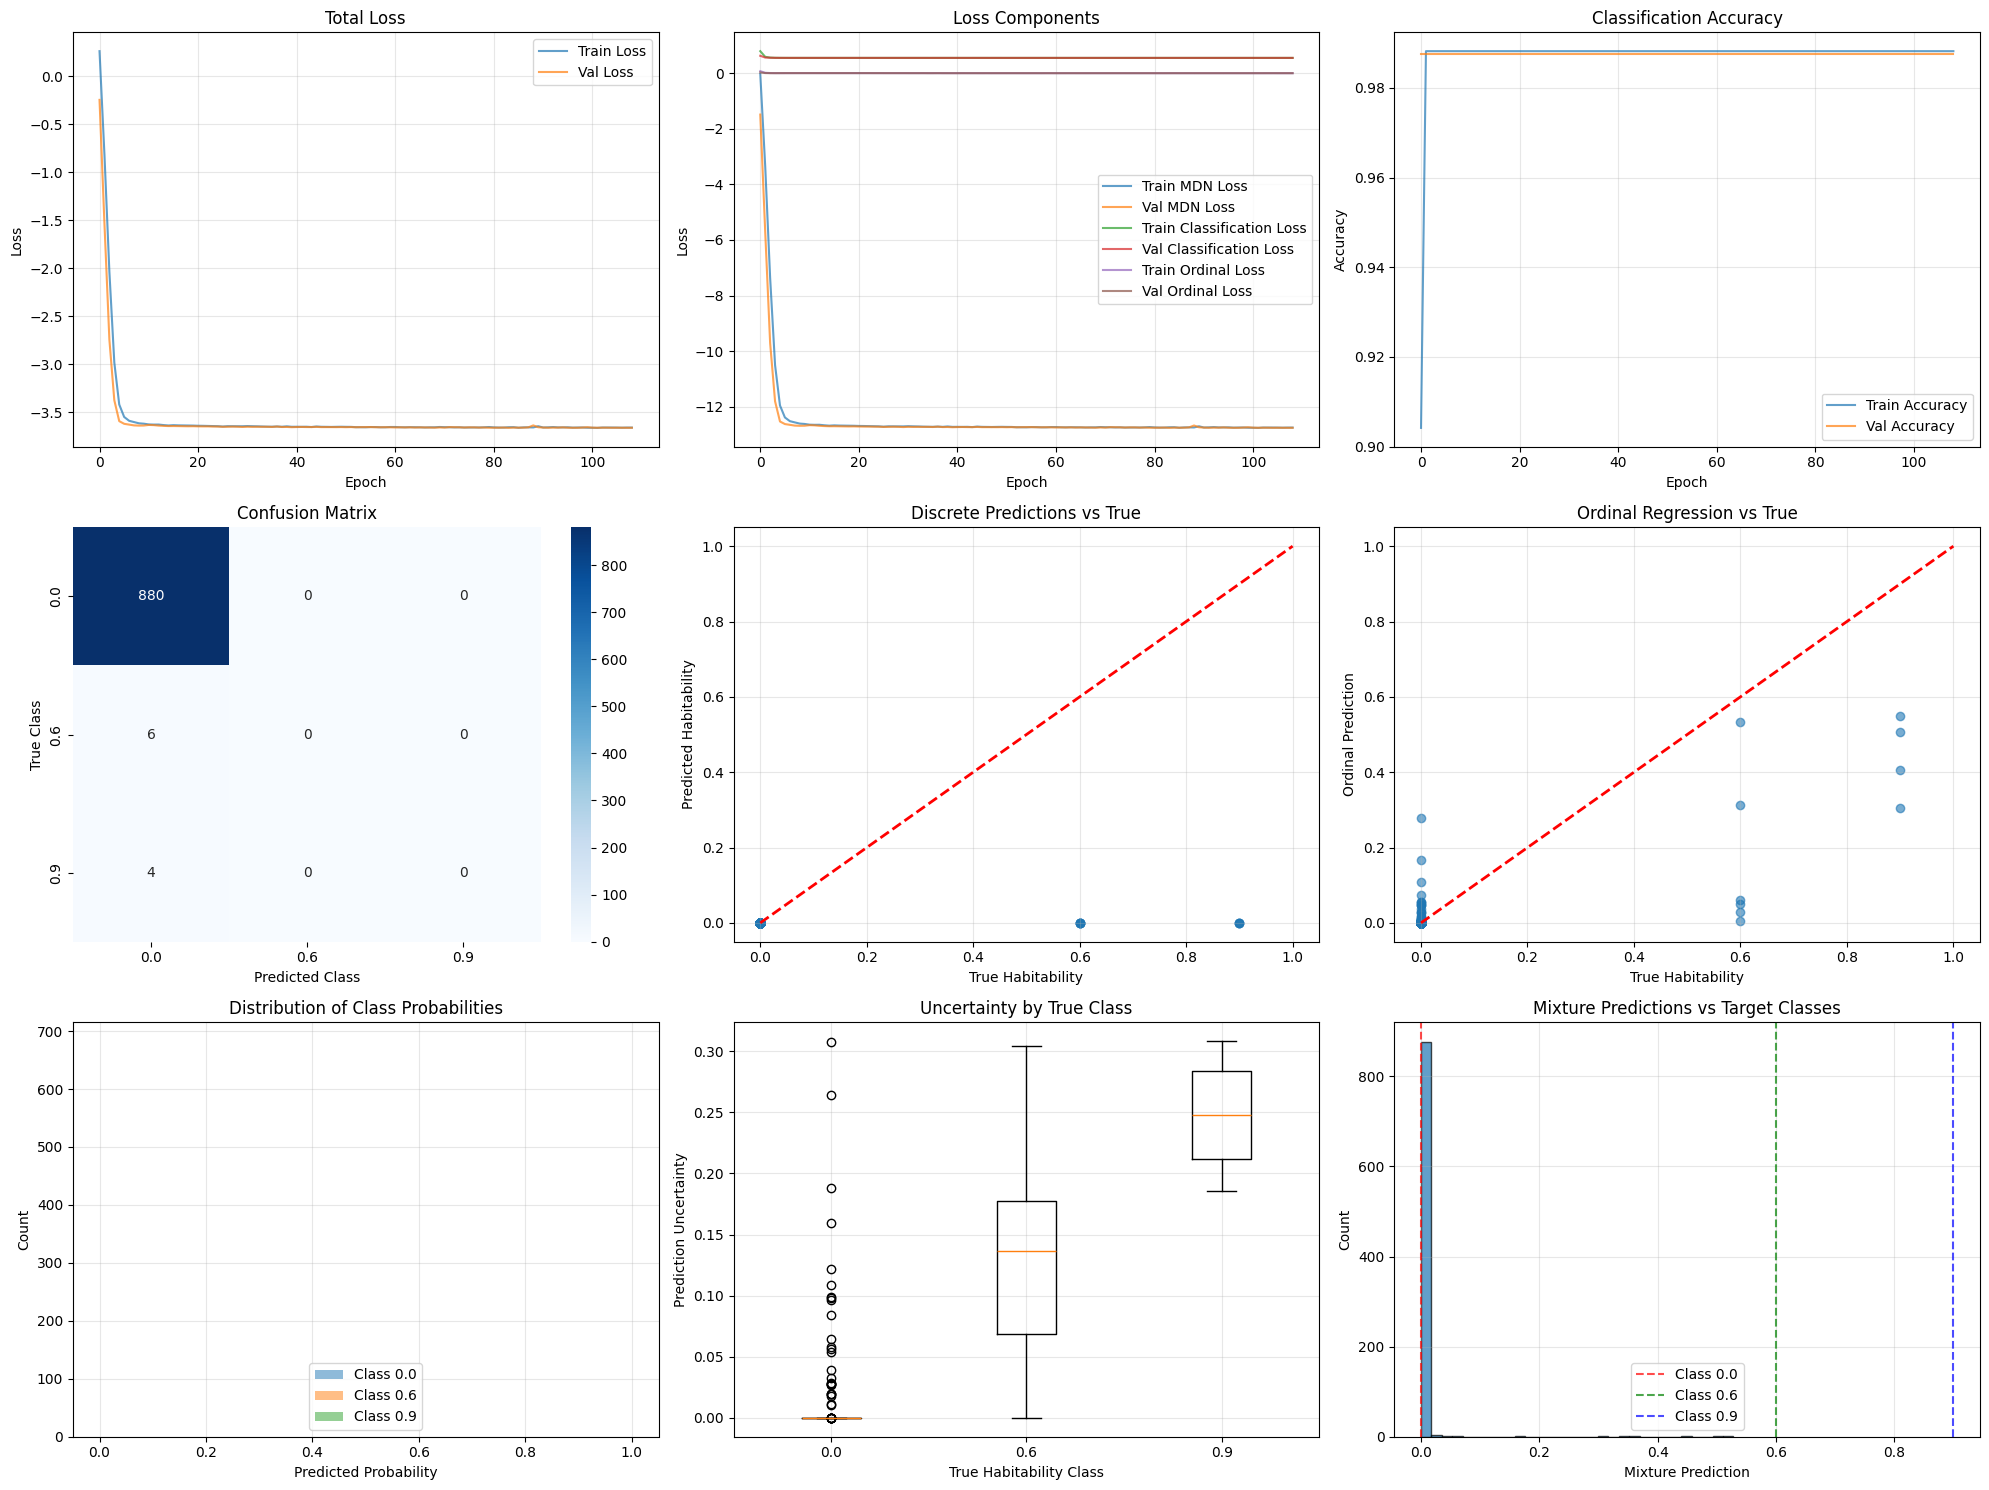


13. FINDING MOST HABITABLE PLANETS
Categorical columns: ['st_spectype']
Numeric columns: 37
Final feature count: 41

Top 10 Most Habitable Planets (discrete habitability):
      pl_name  predicted_habitability  habitable_probability  prob_moderate_habitable  prob_highly_habitable  ordinal_prediction  prediction_uncertainty  confidence_score  pl_rade  pl_eqt  pl_bmasse  st_teff
  Kepler-22 b                     0.0                    0.0                      0.0                    0.0              0.4965                  0.2089               0.0     2.10   279.0     9.1000   5596.0
   HD 40307 g                     0.0                    0.0                      0.0                    0.0              0.4647                  0.2311               0.0     2.56   255.0     7.1000   4956.0
     GJ 514 b                     0.0                    0.0                      0.0                    0.0              0.5109                  0.2143               0.0     2.13   202.0     5.2000   37

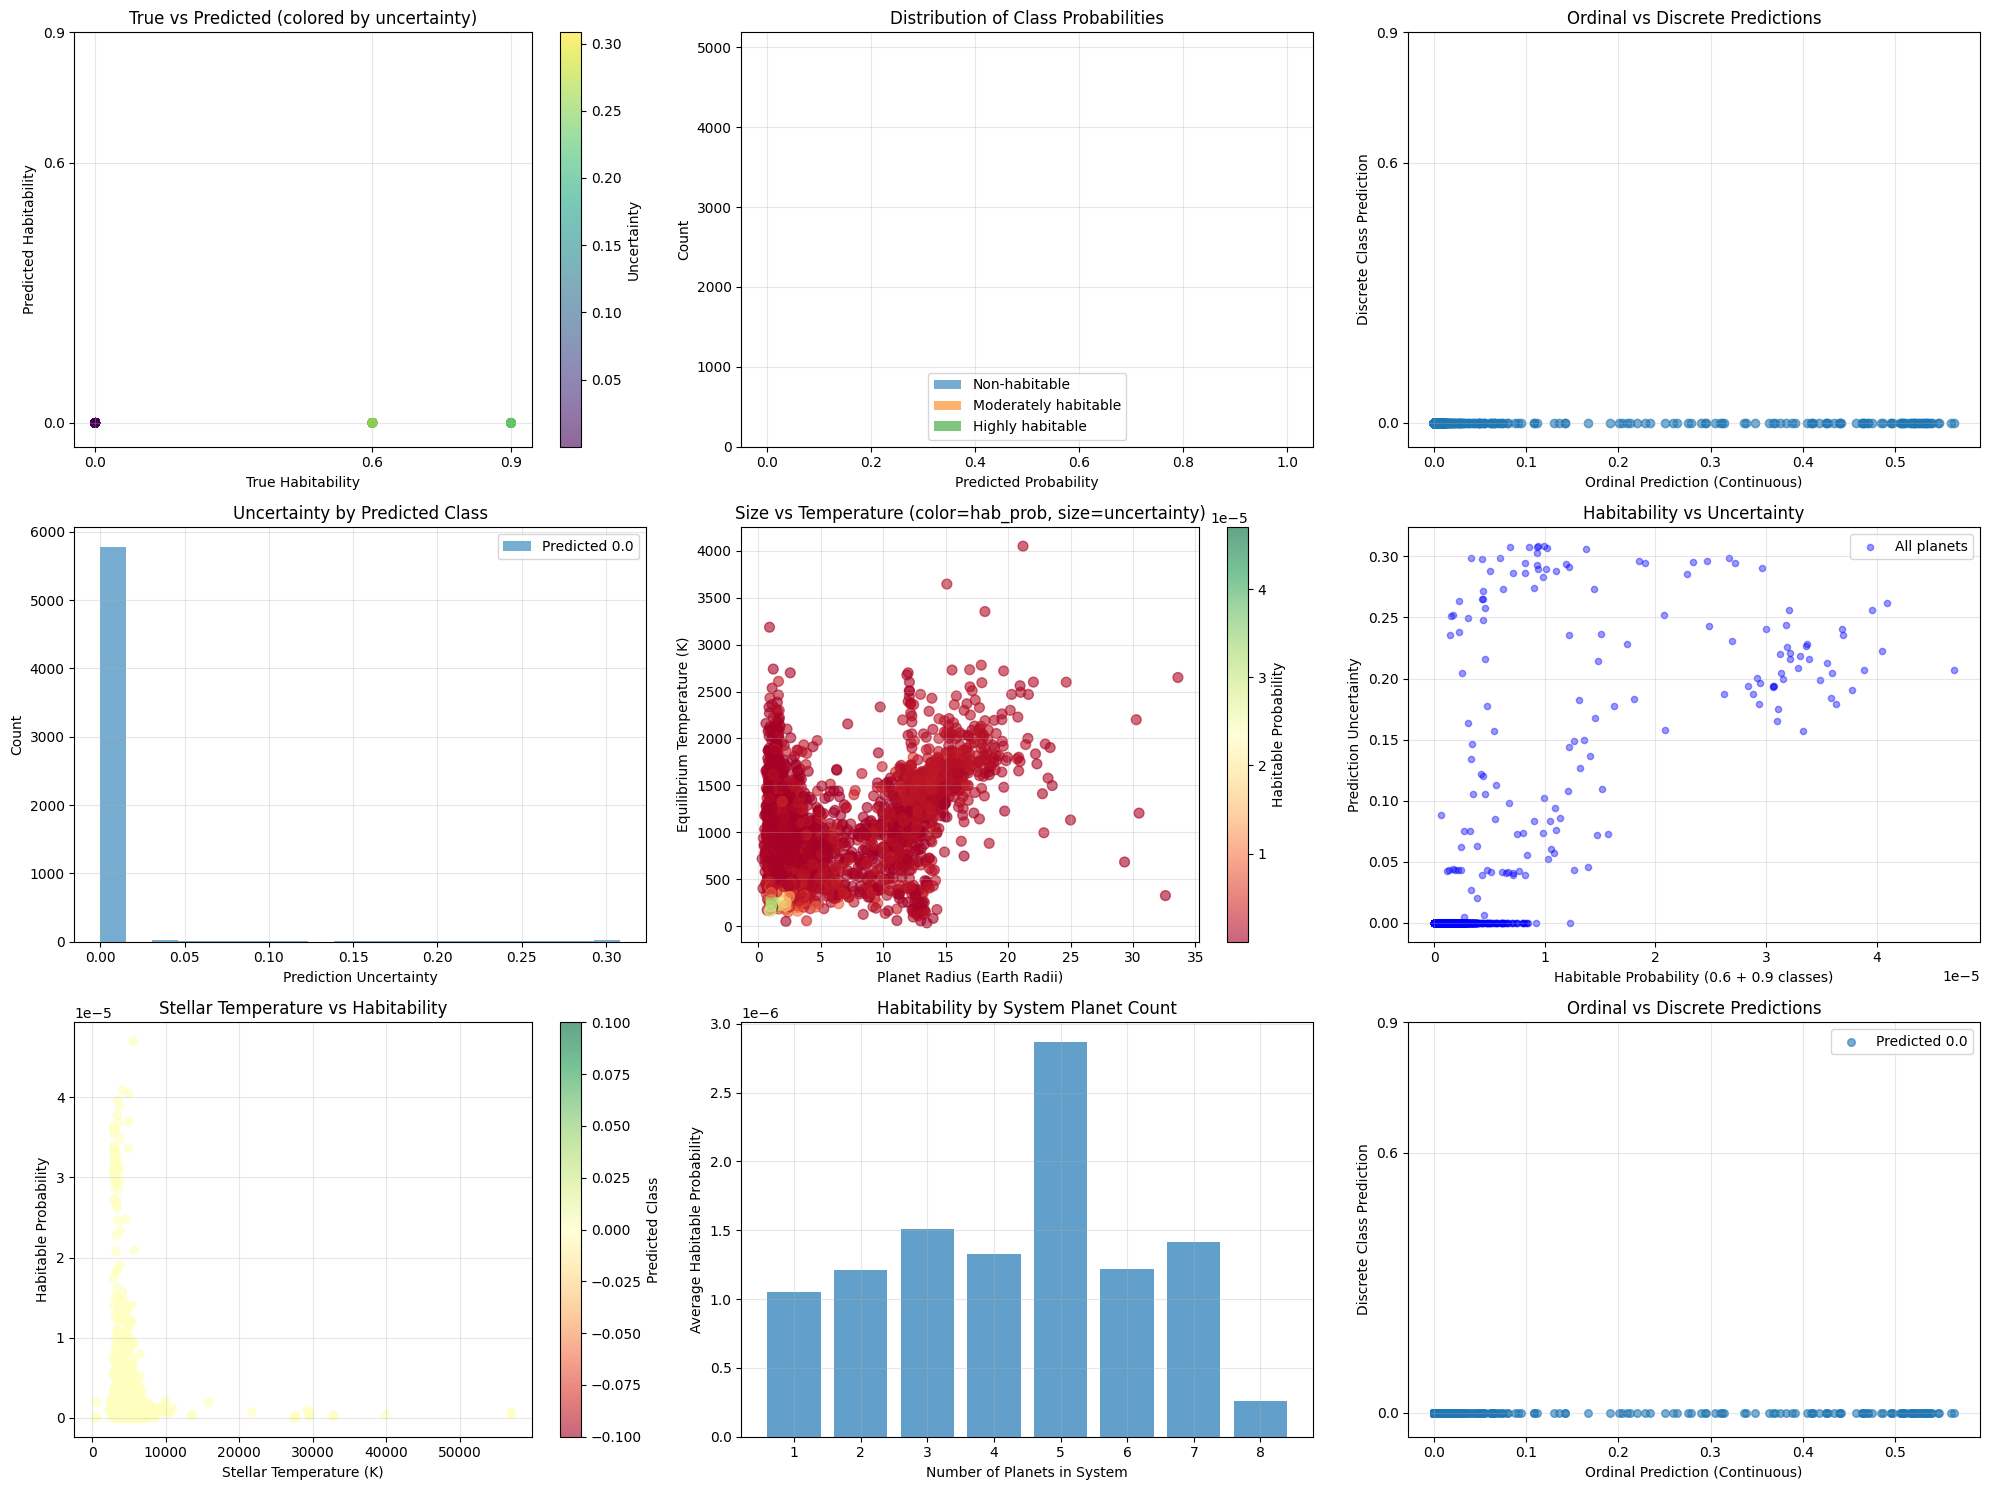


Testing with example planet...
Categorical columns: ['st_spectype']
Numeric columns: 34
Final feature count: 0

Example Prediction Results:
  Predicted habitability class: 0.0
  Class probabilities:
    prob_0.0: 1.0000
    prob_0.6: 0.0000
    prob_0.9: 0.0000
  Ordinal prediction: 0.0000
  Uncertainty level: Low
  Confidence score: 1.0000

Saving trained model...
Model saved to discrete_mdn_habitability_model.pth
Preprocessing objects saved

Discrete habitability pipeline completed!


In [ ]:
results = quick_start_discrete_mdn('modified_exoplanet_habitability.csv')